In [66]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
from ase.io import read

# Set global matplotlib rc parameters for better readability
plt.rcParams.update({
    'font.size': 14,           # Increase the font size
    'font.weight': 'bold',     # Make the font bold
    'axes.labelsize': 16,      # Axis label size
    'axes.titlesize': 18,      # Title size
    'axes.labelweight': 'bold',  # Bold axis labels
    'xtick.labelsize': 14,     # X-axis tick label size
    'ytick.labelsize': 14,     # Y-axis tick label size
    'xtick.major.width': 1.2,  # X-axis major tick width
    'ytick.major.width': 1.2,  # Y-axis major tick width
    'axes.linewidth': 1.5,     # Axis line width
})

### Helper functions

In [67]:
def find_peak(E, T, xlim):
    mask = (E >= xlim[0]) & (E <= xlim[1])
    if np.any(mask):
        max_idx = np.argmax(T[mask])
        peak_height = T[mask][max_idx]
        peak_position = E[mask][max_idx]
        return peak_position, peak_height
    else:
        return None, None

def plot_atomic_positions_with_occupancy(atoms, element_colors, occupancy):

    fig, ax = plt.subplots(figsize=(10, 10))
    positions = atoms.positions
    x = positions[:, 0]
    y = positions[:, 1]

    colors = [element_colors[atom.symbol] for atom in atoms]

    ax.scatter(x, y, color=colors, s=300)

    occupancy_index = 0
    for i, (xi, yi, atom) in enumerate(zip(x, y, atoms)):
        ax.text(xi, yi, str(i), color='black', fontsize=9, ha='center', va='center')


        if atom.symbol in ['C', 'N']:
            ax.text(
                xi + 0.2, yi,
                f"{occupancy[occupancy_index]:.2f}",
                color='blue', fontsize=9, ha='left', va='center'
            )
            occupancy_index += 1

    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    ax.set_title('Atomic Positions with Occupancy')

    plt.show()


In [68]:
atoms = read('dft/device/scatt.xyz')
filtered_atoms = atoms[[atom.symbol not in ['H', 'Au'] for atom in atoms]]
element_colors = {'C': 'cyan', 'N': 'green'}


### Leads self energy

In [69]:
self_energy = np.load("output/lowdin/self_energy.npy",allow_pickle=True)

In [70]:
leftlead_self_energy = self_energy[0]
rightlead_self_energy = self_energy[1]

In [71]:
leftlead_self_energy

In [72]:
leftlead_self_energy = np.array(leftlead_self_energy)
leftlead_self_energy.shape

()

### No Lowdin

In [73]:
data_folder = "output/no_lowdin"
z_ret = np.load(f"{data_folder}/retarded_energies.npy")
energies = z_ret.real
eigvals_bare = np.load(f"{data_folder}/eigvals_Hbare.npy")
eigvals_eff = np.load(f"{data_folder}/eigvals_Heff.npy")
dos = np.load(f"{data_folder}/dft_dos.npy")
_,T = np.load(f"{data_folder}/dft_transmission.npy")
Eref, Tref_dft = np.load("reference/ET_dft.npy")

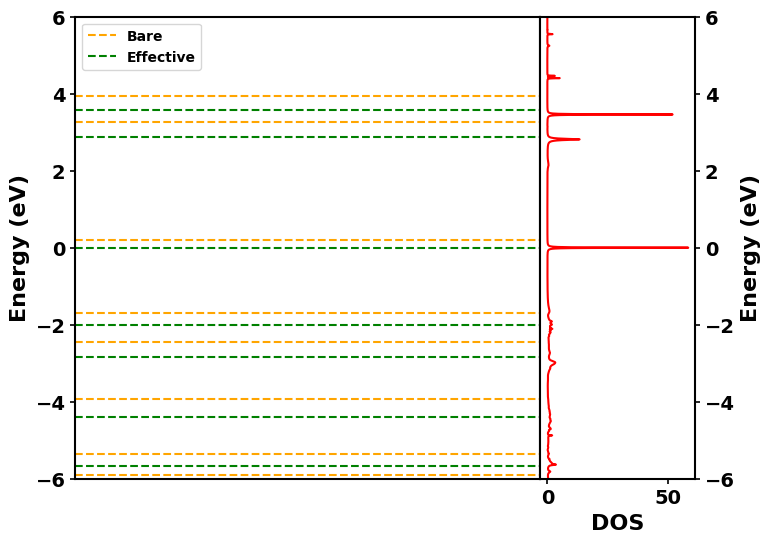

In [74]:
fig, (ax_eigen, ax_dos) = plt.subplots(1, 2, figsize=(8, 6), gridspec_kw={'width_ratios': [3, 1]})

for eig_bare in eigvals_bare:
    ax_eigen.axhline(eig_bare, linestyle='--', color='orange', label='Bare' if eig_bare == eigvals_bare[0] else None)
for eig_eff in eigvals_eff:
    ax_eigen.axhline(eig_eff, linestyle='--', color='green', label='Effective' if eig_eff == eigvals_eff[0] else None)

ax_eigen.set_ylabel("Energy (eV)")
ax_eigen.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax_eigen.legend(loc='upper left', fontsize=10)

ax_dos.plot(dos, energies, color='red', label='DOS')
ax_dos.set_xlabel("DOS")
ax_dos.yaxis.set_label_position("right")
ax_dos.yaxis.tick_right()

y_min = -6
y_max = 6

ax_eigen.set_ylim(y_min, y_max)
ax_dos.set_ylim(y_min, y_max)

ax_dos.set_yticks(ax_eigen.get_yticks())
ax_dos.set_ylabel("Energy (eV)")


plt.subplots_adjust(wspace=0)
plt.show()


In [75]:
# Find all peaks
peaks, properties = find_peaks(dos, height=0)

# Get the heights of the peaks
peak_heights = properties["peak_heights"]

# Find the indices of the n largest peaks
n = 9  # Number of largest peaks to find
largest_peaks_indices = np.argsort(peak_heights)[-n:]

# Get the corresponding energy positions and heights
largest_peaks_positions = energies[peaks[largest_peaks_indices]]
largest_peaks_heights = dos[peaks[largest_peaks_indices]]

# Sort the largest peaks by increasing energy position
sorted_indices = np.argsort(largest_peaks_positions)
sorted_positions = largest_peaks_positions[sorted_indices]
sorted_heights = largest_peaks_heights[sorted_indices]

# Print the positions and heights of the largest peaks in increasing energy order
print("Energy eigenstates (in eV):", eigvals_eff)
print("Positions of the largest peaks (in eV):", sorted_positions)
print("Heights of the largest peaks:", sorted_heights)


Energy eigenstates (in eV): [-6.63593217e+00 -5.68099396e+00 -4.40898902e+00 -2.84754829e+00
 -2.00819522e+00  9.27448665e-04  2.86647633e+00  3.58736183e+00
  7.00083221e+00]
Positions of the largest peaks (in eV): [-7.835e+00 -7.325e+00 -6.434e+00 -6.297e+00  1.000e-03  2.814e+00
  3.461e+00  4.405e+00  6.953e+00]
Heights of the largest peaks: [ 5.9463534   6.7804448  16.47013968 10.1959361  58.5808665  13.42321073
 52.0776558   5.15378787 11.9743728 ]


In [76]:
occupancies = np.load(f"{data_folder}/occupancies_mu0.npy")
total_occupancy = np.sum(occupancies)
total_occupancy

10.398743131477257

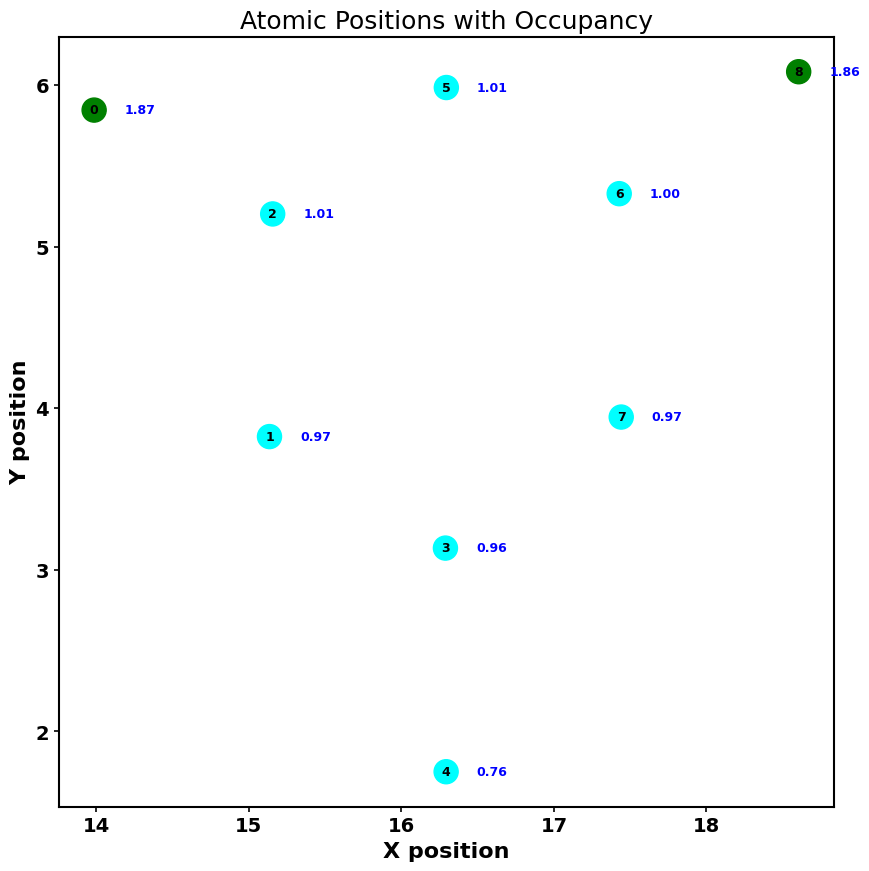

In [77]:
plot_atomic_positions_with_occupancy(filtered_atoms, element_colors, occupancies)

In [78]:
occupancies = np.load(f"{data_folder}/occupancies_mu1e-3.npy")
total_occupancy = np.sum(occupancies)
total_occupancy

10.787299188461592

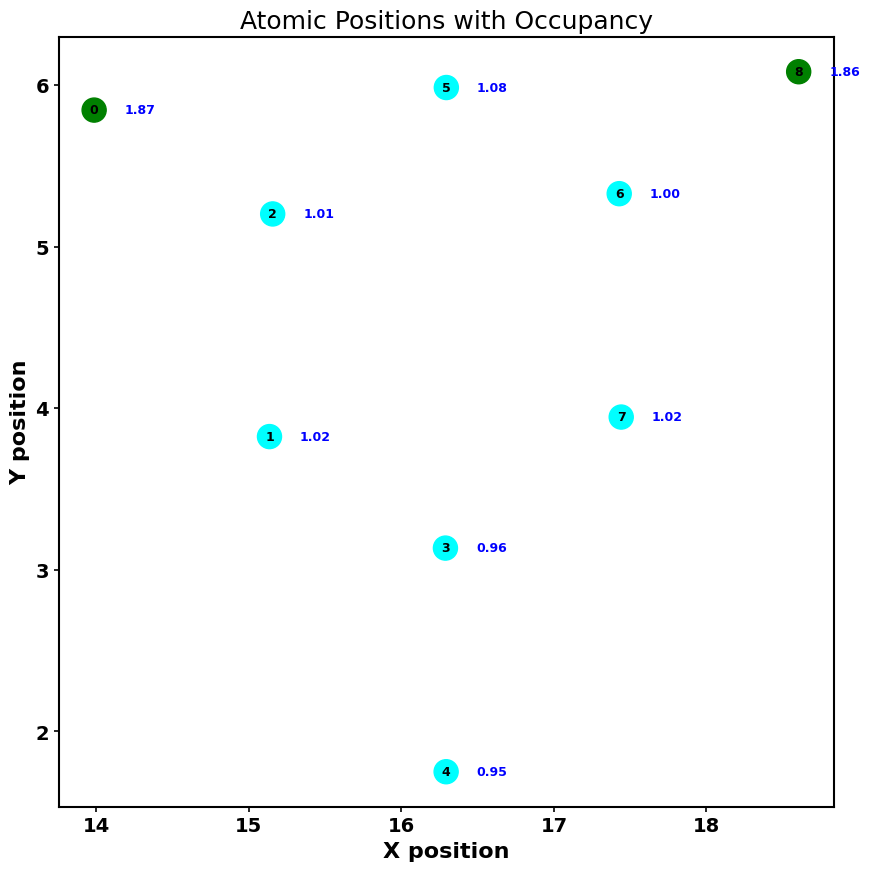

In [79]:
plot_atomic_positions_with_occupancy(filtered_atoms, element_colors, occupancies)

Reference DFT Peak: Position = -0.0000 eV, Height = 2.5929e-03
Computed DFT Peak: Position = 0.0040 eV, Height = 2.7427e-03+0.0000e+00j


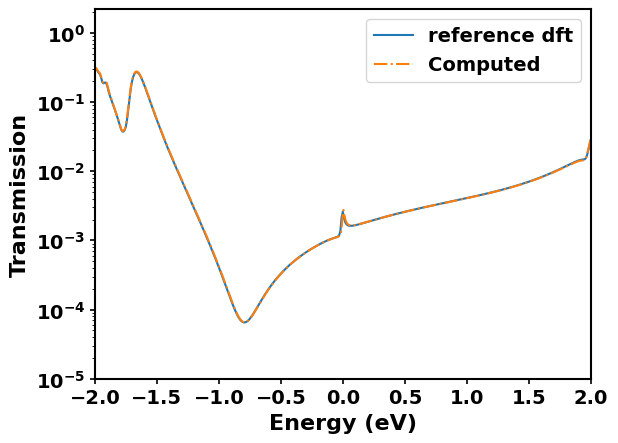

In [80]:
# Find and print the peak for the reference data
ref_peak_position, ref_peak_height = find_peak(Eref, Tref_dft, (-0.2, 0.2))
print(f"Reference DFT Peak: Position = {ref_peak_position:.4f} eV, Height = {ref_peak_height:.4e}")

# Plot the reference DFT data
plt.plot(Eref, Tref_dft, label="reference dft")

# Find and print the peak for the computed data
computed_peak_position, computed_peak_height = find_peak(energies, T, (-0.2, 0.2))
print(f"Computed DFT Peak: Position = {computed_peak_position:.4f} eV, Height = {computed_peak_height:.4e}")

plt.plot(energies, T,'-.',label="Computed")


# Set the y-axis to a logarithmic scale to better visualize the transmission data
plt.yscale("log")
plt.xlim(-2, 2)
plt.ylim(bottom=1e-5)

# Add legend and labels
plt.legend()
plt.xlabel("Energy (eV)")
plt.ylabel("Transmission")

# Show the plot
plt.show()


### Lowdin

In [81]:
data_folder = "output/lowdin"
eigvals_bare = np.load(f"{data_folder}/eigvals_Hbare.npy")
eigvals_eff = np.load(f"{data_folder}/eigvals_Heff.npy")
_,T = np.load(f"{data_folder}/dft_transmission.npy")
dos = np.load(f"{data_folder}/dft_dos.npy")
Eref, Tref_dft = np.load("reference/ET_dft.npy")
de = 0.01
energies = np.arange(-2, 2 + de / 2.0, de).round(7)

In [82]:
occupancies = np.load(f"{data_folder}/occupancies.npy")
total_occupancy = np.sum(occupancies)
total_occupancy

10.787299188461565

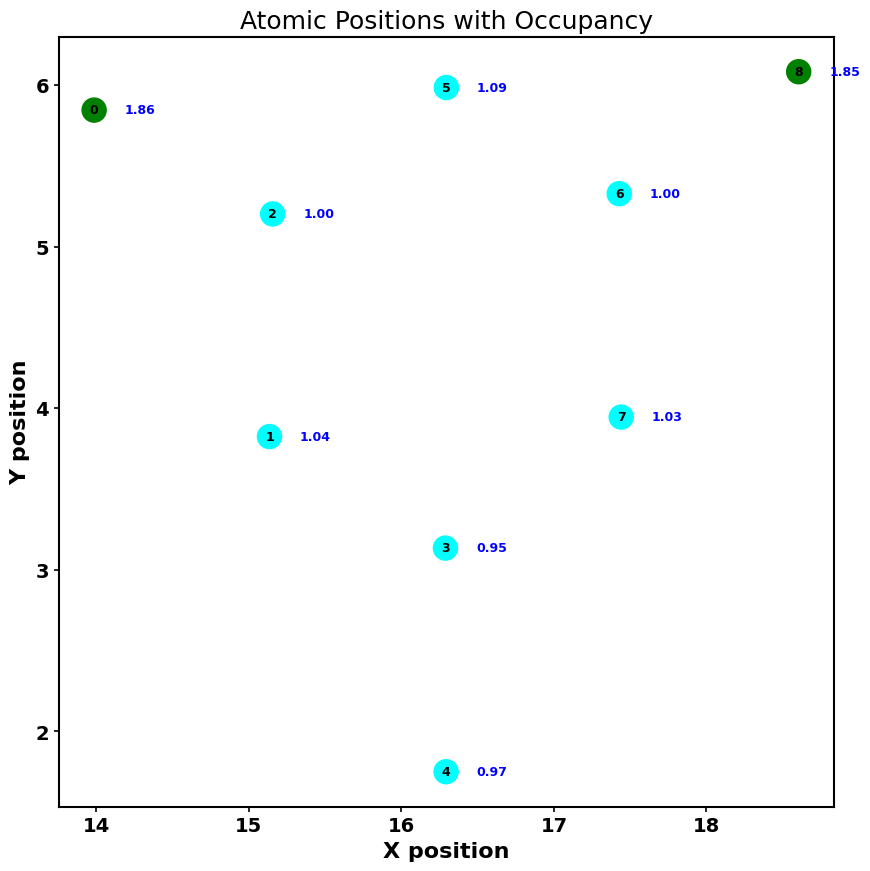

In [83]:
plot_atomic_positions_with_occupancy(filtered_atoms, element_colors, occupancies)

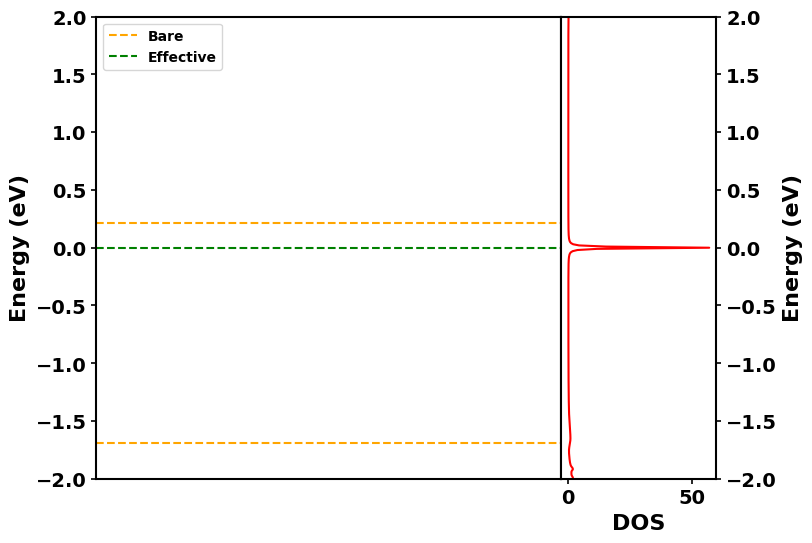

In [84]:
fig, (ax_eigen, ax_dos) = plt.subplots(1, 2, figsize=(8, 6), gridspec_kw={'width_ratios': [3, 1]})

for eig_bare in eigvals_bare:
    ax_eigen.axhline(eig_bare, linestyle='--', color='orange', label='Bare' if eig_bare == eigvals_bare[0] else None)
for eig_eff in eigvals_eff:
    ax_eigen.axhline(eig_eff, linestyle='--', color='green', label='Effective' if eig_eff == eigvals_eff[0] else None)

ax_eigen.set_ylabel("Energy (eV)")
ax_eigen.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax_eigen.legend(loc='upper left', fontsize=10)

ax_dos.plot(dos, energies, color='red', label='DOS')
ax_dos.set_xlabel("DOS")
ax_dos.yaxis.set_label_position("right")
ax_dos.yaxis.tick_right()

y_min = -2
y_max = 2

ax_eigen.set_ylim(y_min, y_max)
ax_dos.set_ylim(y_min, y_max)

ax_dos.set_yticks(ax_eigen.get_yticks())
ax_dos.set_ylabel("Energy (eV)")


plt.subplots_adjust(wspace=0)
plt.show()


In [85]:
# Find all peaks
peaks, properties = find_peaks(dos, height=0)

# Get the heights of the peaks
peak_heights = properties["peak_heights"]

# Find the indices of the n largest peaks
n = 1  # Number of largest peaks to find
largest_peaks_indices = np.argsort(peak_heights)[-n:]

# Get the corresponding energy positions and heights
largest_peaks_positions = energies[peaks[largest_peaks_indices]]
largest_peaks_heights = dos[peaks[largest_peaks_indices]]

# Sort the largest peaks by increasing energy position
sorted_indices = np.argsort(largest_peaks_positions)
sorted_positions = largest_peaks_positions[sorted_indices]
sorted_heights = largest_peaks_heights[sorted_indices]

# Print the positions and heights of the largest peaks in increasing energy order
print("Energy eigenstates (in eV):", eigvals_eff)
print("Positions of the largest peaks (in eV):", sorted_positions)
print("Heights of the largest peaks:", sorted_heights)


Energy eigenstates (in eV): [-6.63593217e+00 -5.68099396e+00 -4.40898902e+00 -2.84754829e+00
 -2.00819522e+00  9.27448665e-04  2.86647633e+00  3.58736183e+00
  7.00083221e+00]
Positions of the largest peaks (in eV): [0.]
Heights of the largest peaks: [56.98648193]


Reference DFT Peak: Position = -0.0000 eV, Height = 2.5929e-03
Computed DFT Peak: Position = 0.0000 eV, Height = 2.5365e-03+0.0000e+00j


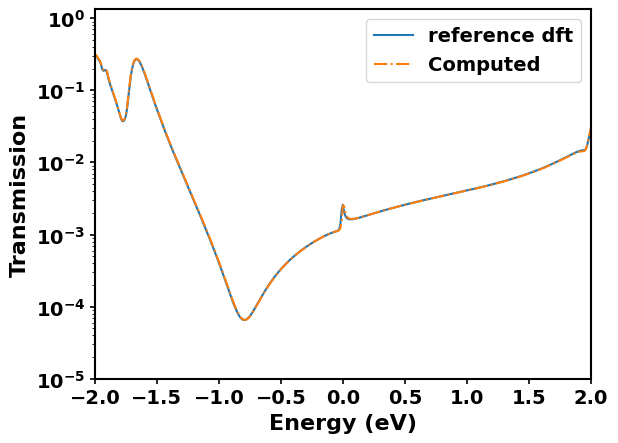

In [86]:
# Find and print the peak for the reference data
ref_peak_position, ref_peak_height = find_peak(Eref, Tref_dft, (-0.2, 0.2))
print(f"Reference DFT Peak: Position = {ref_peak_position:.4f} eV, Height = {ref_peak_height:.4e}")

# Plot the reference DFT data
plt.plot(Eref, Tref_dft, label="reference dft")

# Find and print the peak for the computed data
computed_peak_position, computed_peak_height = find_peak(energies, T, (-0.2, 0.2))
print(f"Computed DFT Peak: Position = {computed_peak_position:.4f} eV, Height = {computed_peak_height:.4e}")

plt.plot(energies, T,'-.',label="Computed")


# Set the y-axis to a logarithmic scale to better visualize the transmission data
plt.yscale("log")
plt.xlim(-2, 2)
plt.ylim(bottom=1e-5)

# Add legend and labels
plt.legend()
plt.xlabel("Energy (eV)")
plt.ylabel("Transmission")

# Show the plot
plt.show()
